In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>div.prompt {display:none}</style>"))
display(HTML("<style>div.input {display:none}</style>"))

from ipywidgets import interact, IntSlider

import datetime
import plotly.express as px

from mplsoccer import Pitch, VerticalPitch
import matplotlib.pyplot as plt

from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
from matplotlib import image

current_period = 0

In [2]:
lines = []

filename = 'data.txt'
with open(filename, encoding='UTF-8') as file:
    for line in file:
        if line == '\n': continue
        lines.append(line.rstrip())

In [3]:
# Meta data
position_data = pd.Series({'GK': 1, 'DF': 2, 'MF': 3, 'FW': 4})
max_players = 11

points_data = {}
points_data['GK'] = pd.Series({'Goal': 10,
                               'Assist': 3,
                               'CS': 5,
                               'Penalty': 3,
                               'Save': 2,
                               'OG': -1,
                               'Miss': -2,
                               'Red': -2,
                              })

points_data['DF'] = pd.Series({'Goal': 7,
                               'Assist': 3,
                               'CS': 4,
                               'Penalty': 2,
                               'Save': 10,
                               'OG': -2,
                               'Miss': -2,
                               'Red': -2,
                              })

points_data['MF'] = pd.Series({'Goal': 6,
                               'Assist': 3,
                               'CS': 0,
                               'Penalty': 2,
                               'Save': 10,
                               'OG': -2,
                               'Miss': -2,
                               'Red': -2,
                              })

points_data['FW'] = pd.Series({'Goal': 5,
                               'Assist': 3,
                               'CS': 0,
                               'Penalty': 2,
                               'Save': 10,
                               'OG': -2,
                               'Miss': -2,
                               'Red': -2,
                              })

points_data = pd.DataFrame(points_data).stack().reset_index()
points_data.columns = ['event', 'position', 'points']

In [4]:
managers = []
players = []
country_teams = []
manager_players = {}
events_data = []
period_player_transfers = []
period_events = []
period = 0

i = 0
while i < len(lines):
# for i in np.arange(len(lines)):
    if lines[i].split()[0] == 'Manager':
        manager = lines[i].split()[-2] + ' ' + lines[i].split()[-1]
        managers.append(manager)
        manager_players[manager] = []
        
    if lines[i].split()[0] == 'Country':
        country = lines[i].split()[-1]
        i = i + 1
                
        while lines[i].split()[0] == 'Player':
            player_name = lines[i][10:]
            players.append([lines[i].split()[1], player_name])
            country_teams.append([country, player_name])
            i = i + 1
        i = i - 1

    # Assume managers have been populated by this point
    if lines[i].split()[0] == 'Draft':
        while lines[i].split()[0] == 'Draft':         
            for manager in managers:
                player = lines[i][6:]
                manager_players[manager].append(player)
                i = i + 1
            
            if np.all([len(manager_players[manager]) == max_players for manager in managers]):
                break;
            
            for manager in managers[::-1]:
                player = lines[i][6:]
                manager_players[manager].append(player)
                i = i + 1
                
            if i == len(lines): break;
        i = i - 1
    
    if i >= len(lines): break;
    
    if lines[i].split()[0] == 'Out':
        period_player_transfers.append([period, lines[i][4:], lines[i+1][3:]])        
        if i >= len(lines): break;
        
    if lines[i].split()[0] == 'Transfer':
        period = period + 1
        
    if lines[i].split()[0] == 'Assist':
        player = lines[i][7:]
        events_data.append([period, lines[i].split()[0], player])
        
    if lines[i].split()[0] == 'Goal':
        player = lines[i][5:]
        events_data.append([period, lines[i].split()[0], player])        
        
    if lines[i].split()[0] == 'Miss':
        player = lines[i][5:]
        events_data.append([period, lines[i].split()[0], player])
        
    if lines[i].split()[0] == 'Save':
        player = lines[i][5:]
        events_data.append([period, lines[i].split()[0], player])        
        
    if lines[i].split()[0] == 'CS':
        player = lines[i][3:]
        events_data.append([period, lines[i].split()[0], player])
        
    if lines[i].split()[0] == 'OG':
        player = lines[i][3:]
        events_data.append([period, lines[i].split()[0], player])  
        
    if lines[i].split()[0] == 'Red':
        player = lines[i][4:]
        events_data.append([period, lines[i].split()[0], player])
        
    if lines[i].split()[0] == 'Penalty':
        player = lines[i][8:]
        events_data.append([period, lines[i].split()[0], player])        

    i = i + 1
    
players = pd.DataFrame(players)
players.columns = ['position', 'player_name']    
    
events_data = pd.DataFrame(events_data)
events_data.columns = ['period', 'event', 'player_name']    

country_teams = pd.DataFrame(country_teams)
country_teams.columns = ['country', 'player_name']

In [5]:
country_list = country_teams['country'].unique()
country_flag_locations = 'flags\\'

In [6]:
events_data = pd.merge(events_data,
                       players,
                       on=['player_name'],
                       how='left')


events_data = pd.merge(events_data,
                       points_data,
                       on=['position', 'event'],
                       how='left')

In [7]:
period_player_transfers = pd.DataFrame(period_player_transfers)
period_player_transfers.columns = ['period', 'in', 'out']

periods = np.sort(period_player_transfers['period'].unique())

In [8]:
player_name_short_list = []

for player in players['player_name']:
    if len(player.split()) == 1:
        player_name_short_list.append(player.split()[0])
    else:
        player_name_short = player.split()[-1]
        
        for i in player.split()[:-1]:
            player_name_short = player_name_short + " {}.".format(i[0])
        player_name_short_list.append(player_name_short)
    
players['player_name_short'] = player_name_short_list

In [9]:
manager_players_picks = pd.DataFrame(manager_players).stack().reset_index()
manager_players_picks.columns = ['pick_number', 'manager', 'player_name']
manager_players_initial = manager_players_picks[['manager', 'player_name']]

In [10]:
manager_players_full = []

for period in periods:
    if period == 0:
        manager_players_temp = manager_players_initial.copy()
    else:
        manager_players_temp = manager_players_temp_previous.copy()
    
    manager_players_temp['period'] = period
    
    period_transfers = period_player_transfers[period_player_transfers['period'] == period]
    if len(period_transfers) == 0: continue
        
    for i in np.arange(len(period_transfers)):
        manager_players_temp = manager_players_temp.replace({
                                    'player_name': {period_transfers.iloc[i]['in']: period_transfers.iloc[i]['out']}
                               })
    manager_players_full.append(manager_players_temp)
    manager_players_temp_previous = manager_players_temp.copy()
    
manager_players_full = pd.concat(manager_players_full)

In [11]:
manager_players_full = pd.merge(manager_players_full,
                                players,
                                on=['player_name'],
                                how='left')

manager_players_full = pd.merge(manager_players_full,
                                position_data.to_frame().rename(columns={0: 'position_number'}),
                                left_on='position',
                                right_index=True,
                                how='left')

manager_players_full = pd.merge(manager_players_full,
                                events_data,
                                on=['period', 'player_name', 'position'],
                                how='left')

manager_players_full = pd.merge(manager_players_full,
                                country_teams,
                                on=['player_name'],
                                how='left')

In [12]:
def position_to_pitch(ax, positions, position_level, position_names):
    for i in np.arange(len(positions)):
        ax.text(positions[i], 
                position_level, 
                position_names['player_name_short'].iloc[i], 
                color="white", 
                fontsize=18, 
                fontweight='bold',
                horizontalalignment='center')
    
#         country_flag_file = "{}{}.webp".format(country_flag_locations, position_names['country'].iloc[i])
# #         country_flag_image = image.imread(country_flag_file)
        
#         from PIL import Image
#         country_flag_image = Image.open(country_flag_file)
        
#         imagebox = OffsetImage(country_flag_image, zoom = 0.15)
#         ab = AnnotationBbox(imagebox, (positions[i], positions), frameon = False)
#         ax.add_artist(ab)
    

def team_to_formation(ax, team):
    gk_level = 116
    df_level = 96
    mf_level = 80
    fw_level = 65
    
    positions = {1: [40],
                 2: [25, 45],
                 3: [20, 40, 60],
                 4: [10, 30, 50, 70],
                 5: [5, 20, 40, 60, 75]}
    
    gk_positions = positions[len(team[team['position']=='GK'])]
    df_positions = positions[len(team[team['position']=='DF'])]
    mf_positions = positions[len(team[team['position']=='MF'])]
    fw_positions = positions[len(team[team['position']=='FW'])]
    
    position_to_pitch(ax, 
                      gk_positions, 
                      gk_level,
                      team[team['position']=='GK'][['player_name_short', 'country']])
    
    position_to_pitch(ax, 
                      df_positions, 
                      df_level,
                      team[team['position']=='DF'][['player_name_short', 'country']])
    
    position_to_pitch(ax, 
                      mf_positions, 
                      mf_level,
                      team[team['position']=='MF'][['player_name_short', 'country']])    
    
    position_to_pitch(ax, 
                      fw_positions, 
                      fw_level,
                      team[team['position']=='FW'][['player_name_short', 'country']])    


In [13]:
def plot_pitch_and_team(manager_players_full_selected):
    pitch = VerticalPitch(pitch_color='grass', line_color='white', stripe=True, half=True)

    # specifying figure size (width, height)
    fig, ax = pitch.draw(figsize=(15, 8))

    team_to_formation(ax, team=manager_players_full_selected)

    plt.show()    

# Teams

In [14]:
latest_period = periods[-1]
manager_players_full_latest = manager_players_full[manager_players_full['period'] == current_period]

## Mitesh

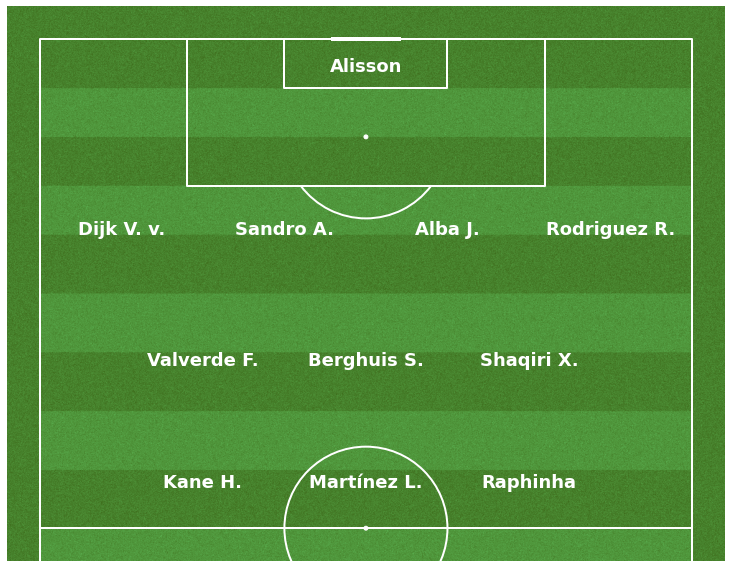

In [15]:
manager = 'Mitesh Patel'
plot_pitch_and_team(manager_players_full_latest[manager_players_full_latest['manager'] == manager])

## Stephen

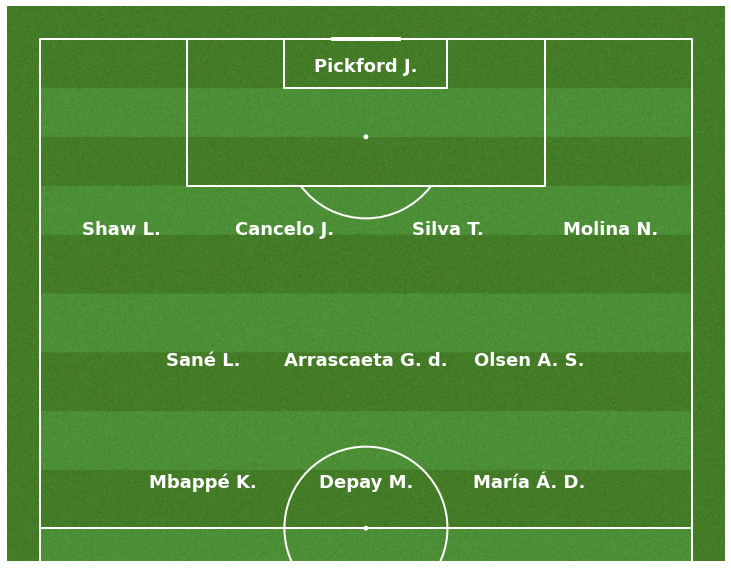

In [16]:
manager = 'Stephen Brooks'
plot_pitch_and_team(manager_players_full_latest[manager_players_full_latest['manager'] == manager])

## Santos

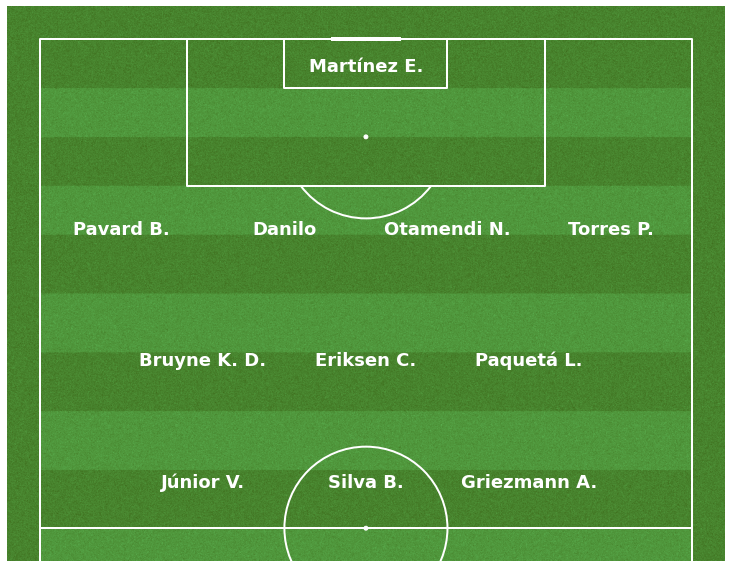

In [17]:
manager = 'Ed Santos'
plot_pitch_and_team(manager_players_full_latest[manager_players_full_latest['manager'] == manager])

## Tom

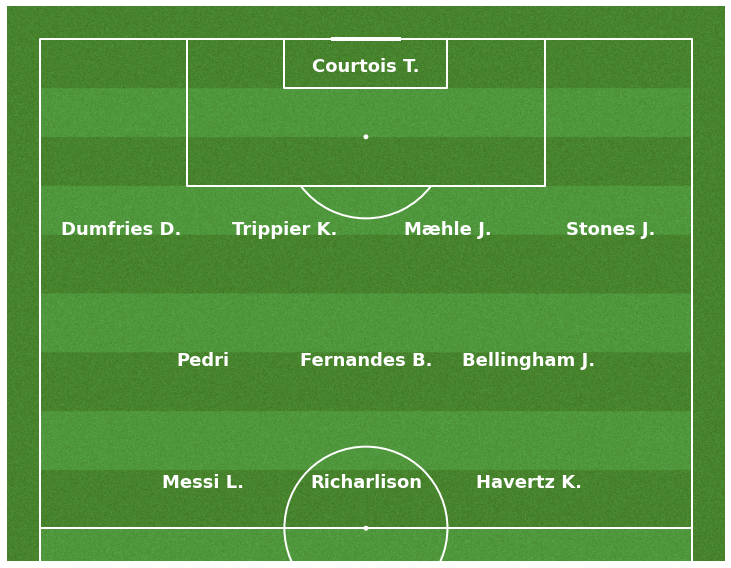

In [18]:
manager = 'Tom Paton'
plot_pitch_and_team(manager_players_full_latest[manager_players_full_latest['manager'] == manager])

## Iain

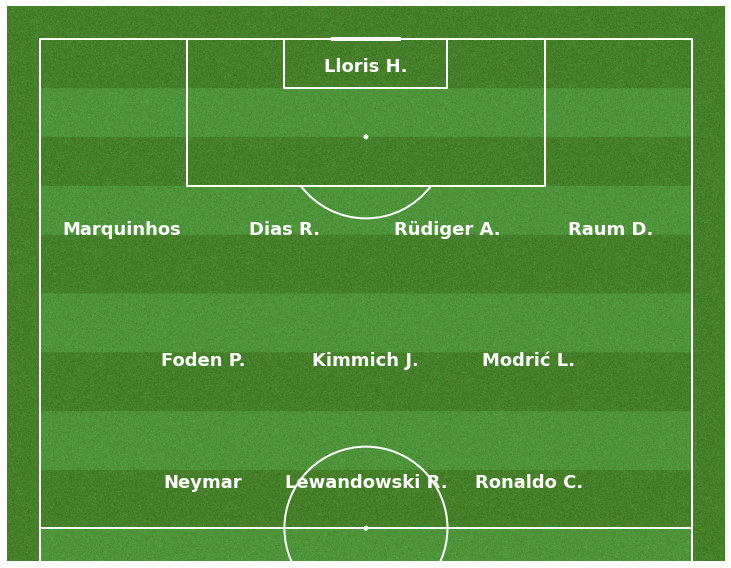

In [19]:
manager = 'Iain Scott'
plot_pitch_and_team(manager_players_full_latest[manager_players_full_latest['manager'] == manager])

# Performance

In [20]:
player_team_performance = (manager_players_full.groupby(['period', 'manager'])['points']
                           .sum().reset_index()
                           .pivot(index='period', columns='manager', values='points').cumsum())

In [21]:
fig = px.line(player_team_performance, title='Period performance')
fig.show()

## Performance rank

In [22]:
(player_team_performance
 .rank(1, ascending=False).astype(int)
 .T.style.background_gradient(cmap='RdBu')
 .set_properties(**{'width': '2em', 'text-align': 'center'}))

## Position rank

In [23]:
(player_team_performance.cumsum()
 .rank(1, ascending=False).astype(int)
 .T.style.background_gradient(cmap='RdBu')
 .set_properties(**{'width':'2em', 'text-align': 'center'}))

## Manager player performances

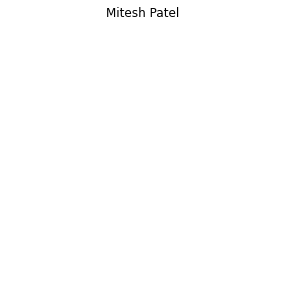

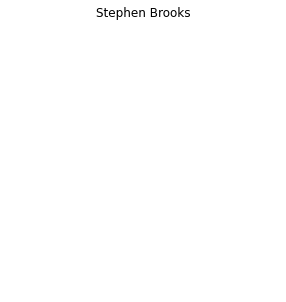

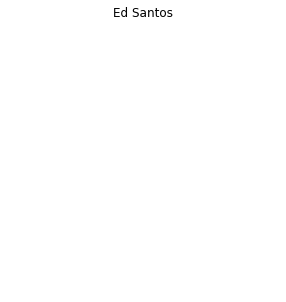

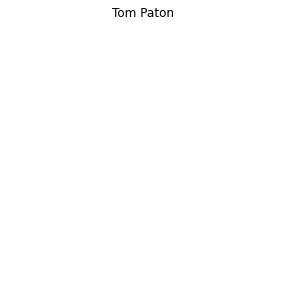

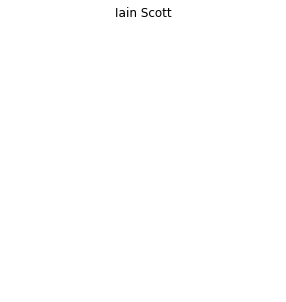

In [24]:
manager_player_performances = (manager_players_full
                               .groupby(['manager', 'player_name'])['points'].sum().reset_index())

for manager in managers:  
    (manager_player_performances[manager_player_performances['manager'] == manager]
     .drop(columns='manager').set_index('player_name').sort_values('points', ascending=False)
     .iloc[:10]
     .plot.pie(y='points', figsize=(5,5), title=manager, legend=False, ylabel=''));

## Players used

In [25]:
fig = px.bar(manager_players_full.groupby('manager')['player_name'].nunique().sort_values(ascending=False),
             title='Most players used', 
             labels={'value':'Number of unique players', 
                     'user_name':''})
fig.layout.update(showlegend=False)
fig.show()